In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import Input, RandomTranslation, RandomZoom, RandomRotation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Dense, Dropout
from timeit import default_timer as timer
from tensorflow.keras.optimizers import Adam 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import plot_model

# Data Loading

In [2]:
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
train_df['label'].unique()

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14], dtype=int64)

In [5]:
# Extract labels and pixels
X_train_all = train_df.values[:,1:].astype(np.float32())
y_train_all = train_df.values[:,0]
X_test = test_df.values[:,1:].astype(np.float32())
y_test = test_df.values[:,0]

In [6]:
# splitting validation set from the training set using stratified splitting
split = StratifiedShuffleSplit(n_splits=1, test_size=2500)
for train_index, test_index in split.split(X_train_all, y_train_all):
    X_train, X_val = X_train_all[train_index], X_train_all[test_index]
    y_train, y_val = y_train_all[train_index], y_train_all[test_index]

In [7]:
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# Data Visualization

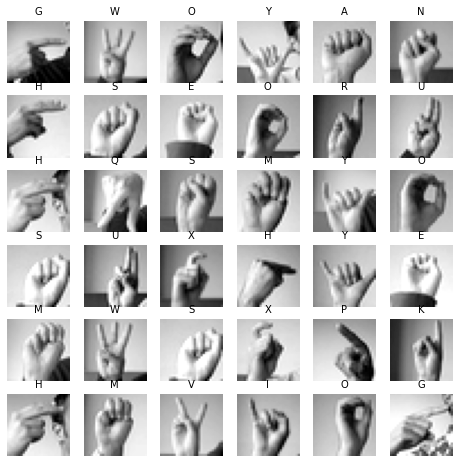

In [8]:
# visualizing random images from the training set
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(8,8))

for ax in axs.reshape(-1):
    idx = np.random.randint(X_train.shape[0])
    ax.set_title(labels[y_train[idx]], size=10)
    ax.axis('off')
    ax.imshow(X_train[idx].reshape((28,28)), cmap='gray');

# Standardzation

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Logistic Regression

In [10]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

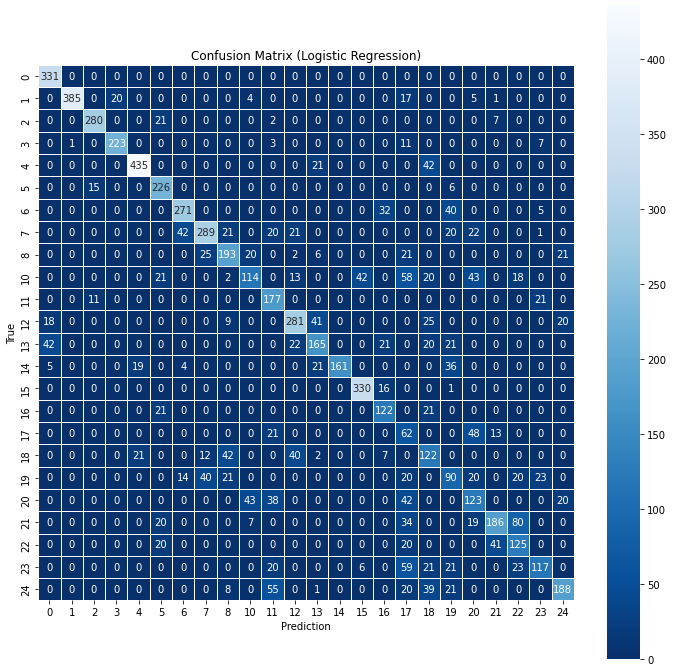

In [11]:
# Confusion matrix
label_all = sorted(np.unique(y_test))

cm_lr = confusion_matrix(y_test, y_pred_lr, labels = label_all)

plt.figure(figsize=(12, 12))
sns.heatmap(cm_lr, annot=True, linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g', xticklabels=label_all, yticklabels=label_all)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

In [12]:
# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Precision: 0.7265
Recall: 0.6966
F1 Score: 0.7018

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       331
           1       1.00      0.89      0.94       432
           2       0.92      0.90      0.91       310
           3       0.92      0.91      0.91       245
           4       0.92      0.87      0.89       498
           5       0.69      0.91      0.78       247
           6       0.82      0.78      0.80       348
           7       0.79      0.66      0.72       436
           8       0.65      0.67      0.66       288
          10       0.61      0.34      0.44       331
          11       0.53      0.85      0.65       209
          12       0.74      0.71      0.73       394
          13       0.64      0.57      0.60       291
          14       1.00      0.65      0.79       246
          15       0.87      0.95      0.91       347
          16       0.62      0.74      0.67       164
       

# K-Nearest Neighbors (KNN)

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

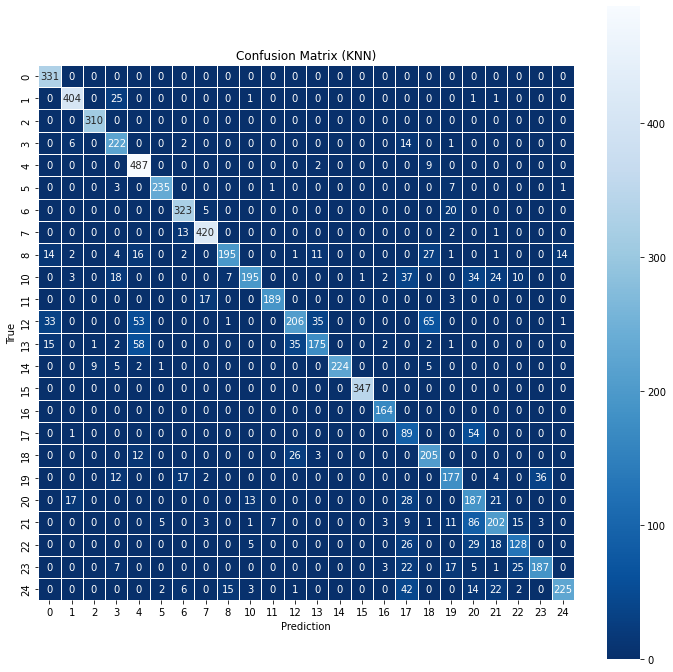

In [14]:
# Calculate the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=label_all)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(cm_knn, annot=True, linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g', xticklabels=label_all, yticklabels=label_all)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix (KNN)')
plt.show()

In [15]:
# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_knn, average='weighted')

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

Precision: 0.8316
Recall: 0.8125
F1 Score: 0.8131

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       331
           1       0.93      0.94      0.93       432
           2       0.97      1.00      0.98       310
           3       0.74      0.91      0.82       245
           4       0.78      0.98      0.87       498
           5       0.97      0.95      0.96       247
           6       0.89      0.93      0.91       348
           7       0.94      0.96      0.95       436
           8       0.89      0.68      0.77       288
          10       0.89      0.59      0.71       331
          11       0.96      0.90      0.93       209
          12       0.77      0.52      0.62       394
          13       0.77      0.60      0.68       291
          14       1.00      0.91      0.95       246
          15       1.00      1.00      1.00       347
          16       0.94      1.00      0.97       164
       

# Convolutional Neural Network

In [16]:
# Reshape pixels
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_val_cnn = X_val.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

In [17]:
# One-hot encode the labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_val_one_hot = tf.keras.utils.to_categorical(y_val)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

In [18]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(25, activation = "softmax"))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1

In [20]:
# Compile the model
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

D:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
# Define early stopping for fine-tuning
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train_cnn, y_train_one_hot, epochs=30, batch_size=64,
                    validation_data=(X_val_cnn, y_val_one_hot),
                    callbacks=[early_stopping])

Epoch 1/30
390/390 [==============================] - 46s 111ms/step - loss: 2.5687 - accuracy: 0.2636 - val_loss: 0.8959 - val_accuracy: 0.6824
Epoch 2/30
390/390 [==============================] - 47s 120ms/step - loss: 0.6682 - accuracy: 0.7744 - val_loss: 0.1918 - val_accuracy: 0.9292
Epoch 3/30
390/390 [==============================] - 49s 125ms/step - loss: 0.1975 - accuracy: 0.9386 - val_loss: 0.0865 - val_accuracy: 0.9752
Epoch 4/30
390/390 [==============================] - 49s 125ms/step - loss: 0.1433 - accuracy: 0.9583 - val_loss: 0.0079 - val_accuracy: 0.9968
Epoch 5/30
390/390 [==============================] - 49s 125ms/step - loss: 0.1046 - accuracy: 0.9727 - val_loss: 0.0106 - val_accuracy: 0.9968
Epoch 6/30
390/390 [==============================] - 49s 125ms/step - loss: 0.1224 - accuracy: 0.9697 - val_loss: 0.0295 - val_accuracy: 0.9936
Epoch 7/30
390/390 [==============================] - 48s 124ms/step - loss: 0.1894 - accuracy: 0.9623 - val_loss: 0.0273 - val_ac

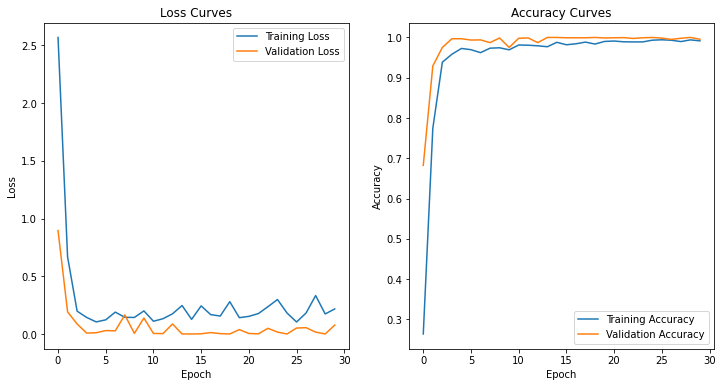

In [23]:
# Extract loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the loss curves for training and validation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot the accuracy curves for training and validation
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

In [24]:
# Make predictions on the test dataset
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

225/225 [==============================] - 4s 15ms/step


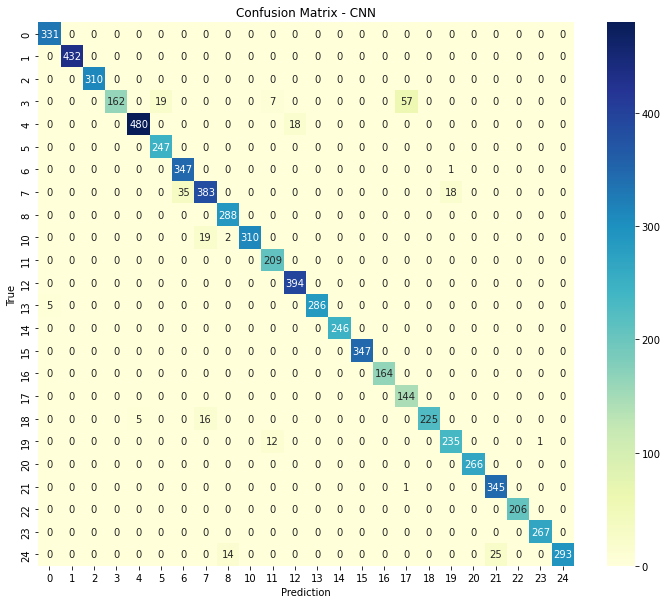


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      0.66      0.80       245
           4       0.99      0.96      0.98       498
           5       0.93      1.00      0.96       247
           6       0.91      1.00      0.95       348
           7       0.92      0.88      0.90       436
           8       0.95      1.00      0.97       288
          10       1.00      0.94      0.97       331
          11       0.92      1.00      0.96       209
          12       0.96      1.00      0.98       394
          13       1.00      0.98      0.99       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       0.71      1.00      0.83       144
   

In [25]:
# Calculate confusion matrix for the test dataset
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='YlGnBu', xticklabels=label_all, yticklabels=label_all)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_cnn))

In [26]:
# Calculate precision, recall, and F1 score
precision_cnn, recall_cnn, f1_score_cnn, _ = precision_recall_fscore_support(y_test, y_pred_cnn, average='weighted')

# Print the results
print(f"Precision: {precision_cnn:.4f}")
print(f"Recall: {recall_cnn:.4f}")
print(f"F1 Score: {f1_score_cnn:.4f}")

Precision: 0.9679
Recall: 0.9644
F1 Score: 0.9639


# Model Prediction

1/1 [==============================] - 0s 23ms/step


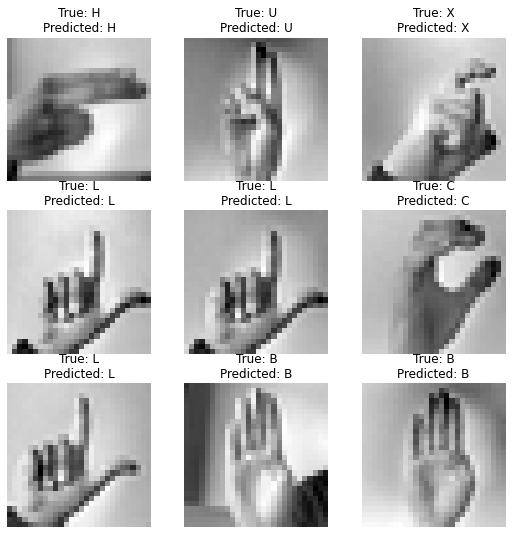

In [27]:
# Choose 9 random images from the test dataset
num_images = 9
random_indices = np.random.choice(X_test_cnn.shape[0], num_images, replace=False)

# Preprocess the images
images = X_test_cnn[random_indices]
true_labels = y_test[random_indices]

# Make predictions using the CNN model
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Plot the images with their true and predicted labels
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {labels[true_labels[i]]}\nPredicted: {labels[predicted_labels[i]]}")
    ax.axis('off')

plt.show()